In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"alji1305","key":"4703b0a6c6a8543e51a6de4131ab05cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import time
import sys
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
from   zipfile    import ZipFile
from   datetime   import datetime
import random
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
#sklearn improts

from sklearn.metrics         import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing   import StandardScaler
from xgboost.sklearn         import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
import time
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score


from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline     import Pipeline
from sklearn.metrics      import accuracy_score
from sklearn.ensemble     import StackingClassifier

In [ ]:
!kaggle competitions download -c icr-identify-age-related-conditions

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 77.8MB/s]


In [ ]:
with ZipFile('icr-identify-age-related-conditions.zip') as zip:
  print(zip.namelist())
  with zip.open(zip.namelist()[0]) as f:
    greeks             = pd.read_csv(f)
  with zip.open(zip.namelist()[1]) as f:
    sample_submission  = pd.read_csv(f)
  with zip.open(zip.namelist()[2]) as f:
    test               = pd.read_csv(f)
  with zip.open(zip.namelist()[3]) as f:
    train              = pd.read_csv(f)

\

In [ ]:
train_id     = train['Id']
train        = train.drop(columns = ['Id'])
target_class = train['Class']
train        = train.drop(columns = ['Class'])

**Add Categorized Alpha**
1. 0 Indicates No Diagnosis
2. 1 Indicates An Age Related Diagnosis

In [ ]:
greeks[['Beta', 'Gamma', 'Delta']].nunique()

In [ ]:
train.isna().sum()

**Deal with BQ and EL Missing Value**
1. See if we can fill it with a univariate correlation --> no we can't correlations are poor

In [ ]:
train.corrwith(train['BQ'])

In [ ]:
train.corrwith(train['EL'])

**Use a Multivariate Correlation Imputer**

In [ ]:
# explicitly require this experimental feature
# from sklearn.experimental import enable_iterative_imputer # noqa
# from sklearn.ensemble     import RandomForestRegressor
# from sklearn.impute       import IterativeImputer

# imp = IterativeImputer(estimator=RandomForestRegressor())
# train = pd.DataFrame(imp.fit_transform(train), columns = train.columns)

**Avoid Loading Everything Again**
1. Save data as pickle file

In [ ]:
import pickle
# with open('train.pckl', 'wb') as pckl:
#   pickle.dump(train, pckl)

with open('train.pckl', 'rb') as pckl:
  train = pickle.load(pckl)

# Exploratory DA

1. Scales of Variable Are Different Standard Scaler

**Find Categorical Column**

In [ ]:
def get_categorical():

  # Iterate all columns and rows
  for col in train.columns:
    for index in train.index:

      # Skip Numerical Columns
      if type(train.loc[index, col]) != str:
        break

      # Print Once
      else:
        print(col)
        break

  return

get_categorical()

EJ_labels          = pd.factorize(train['EJ'])[1]
train['EJ']        = pd.factorize(train['EJ'])[0]

In [ ]:
scaler       = StandardScaler()
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns = train.columns)

In [ ]:
statistics = train_scaled.describe()
statistics = statistics.transpose()

**View Mean of Scaled Data**

In [ ]:
figure = plt.figure(figsize = (10, 7))
plot = sns.barplot(statistics, y = 'mean', x = statistics.index)
plot.set_xticklabels(rotation = 90, labels = statistics.index)
plot.set_title('Mean')

**Median of Data**

In [ ]:
figure = plt.figure(figsize = (10, 7))
plot = sns.barplot(statistics, y = '50%', x = statistics.index)
plot.set_xticklabels(rotation = 90, labels = statistics.index)
plot.set_title('Median')

**Max**

In [ ]:
figure = plt.figure(figsize = (10, 7))
plot = sns.barplot(statistics, y = 'max', x = statistics.index)
plot.set_xticklabels(rotation = 90, labels = statistics.index)
plot.set_title('Max')

**The Data is skewed for a lot of variables**
1. Mean and Median are not approximately equal
2. Definitely a consideration for downstream to remove outliers

**PCA**
1. Using PCA reduces the accuracy

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_scaled, target_class, test_size = 0.15)  # PCA's make it worse
# x_train, x_val, y_train, y_val   = train_test_split(train_scaled, target_class, test_size = 0.15)

**Reset Index for Stratified K Fold Calls**

In [ ]:
x_train = x_train.reset_index().drop(columns = ['index'])
y_train = pd.DataFrame(y_train).reset_index().drop(columns = ['index'])

**Data Targets Split Percentage**

In [ ]:
zero_target = target_class.value_counts()[0]
one_target  = target_class.value_counts()[1]

percent_negative =  zero_target / (zero_target + one_target) * 100
percent_negative

82.49594813614263

**GridSearch Hyperparametrs**
1. Use Cross Validation and K Folds Cross Valdiation

**Bayesian Hyperparameter Optimization**

In [ ]:
!pip install bayesian-optimization

**Loss Function**

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
import time
from sklearn.utils import class_weight


# output of function needs to minimzied
# for a classification problem, were minimizing the accuracy
# so in theory, it's really just having a metric that calculates the accuracy
# then that accuracy is being maximzied in a bayesian fassion
def bayes_opt(n_estimators, subsample, learning_rate, max_depth, colsample_bytree, eta):

  folds     = 5
  skf       = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

  params_gbm                     = {}
  params_gbm['learning_rate']    = learning_rate
  params_gbm['n_estimators']     = int(n_estimators)
  # params_gbm['reg_lambda']       = reg_lambda
  # params_gbm['reg_alpha']        = reg_alpha
  # params_gbm['gamma']            = round(gamma)
  params_gbm['subsample']        = subsample
  params_gbm['max_depth']        = int(max_depth)
  params_gbm['colsample_bytree'] = colsample_bytree
  params_gbm['eta']              = eta


  weights      = class_weight.compute_sample_weight('balanced', y_train)

  scores       = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train)):

    x_train_fold, y_train_fold = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_val, y_val = x_train.iloc[val_idx], y_train.iloc[val_idx]
    watchlist = [(x_train_fold, y_train_fold), (x_val, y_val)]

    scorer     = make_scorer(log_loss)

    xgb_model  = XGBClassifier(**params_gbm,
                               objective = 'binary:logistic',
                               eval_metric = 'logloss')

    xgb_model.fit(x_train_fold, y_train_fold)

    val_preds  = xgb_model.predict_proba(x_val)
    score      = log_loss(y_val, val_preds)
    scores.append(score)



  scores = np.average(scores)

  # maximize 1 - scores (minimize log_loss)
  # function maximizes function so we subtract it from 1 to minimize it
  return 1 - scores



pbounds = {'n_estimators': (50, 200),
          'subsample': (0.5, 1.0),
          'learning_rate':(0.01, 3),
           'max_depth': (3, 10),
           'colsample_bytree': (0.5, 1),
           'eta': (0.2, 0.4)
          }

optimizer   = BayesianOptimization(
    f       = bayes_opt,
    pbounds = pbounds,
    verbose = 2
)

In [ ]:
optimizations = optimizer.maximize(
    init_points = 6,
    n_iter      = 150
)

In [ ]:
test_r = test.drop(columns = ['Id'])
test_r['EJ'] = pd.factorize(test_r['EJ'])[0]

In [ ]:
optimizer.res

In [ ]:

# roc_auc_score(y_test, xgb_model.predict(x_test))

In [ ]:
# submission                         = sample_submission.copy()
# submission[['class_0', 'class_1']] = xgb_model.predict_proba(test_r)
# submission.to_csv('submission.csv', index=False)

In [ ]:
# submission

# Ensemble Modeling Exploration

**Taking A Stacked Classifier Approach**

In [ ]:
x_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.590413,-0.464060,-0.261669,-0.324969,-0.189295,-0.545454,-0.083417,0.689067,-0.104787,-0.239640,...,-0.517222,-0.457833,-0.045644,0.575331,0.268332,-0.410260,3.343342,-0.808929,-0.918829,1.304861
1,-0.462591,0.118890,-0.261669,-0.361731,0.192392,-0.309180,0.061346,-0.647552,-0.067442,-0.089610,...,-0.592442,-0.457833,-0.043400,-0.272399,-1.388246,0.672523,1.125291,-0.082189,1.741549,1.304861
2,0.587379,-0.244547,-0.261669,-0.346439,-0.189295,-0.757407,-0.083417,-0.141609,-0.104787,-0.878686,...,0.665621,-0.118690,-0.029432,-0.220391,-0.840401,-0.410260,-0.455345,-0.669999,-0.826203,-0.815376
3,-0.133904,0.677710,-0.261669,-0.072352,-0.189295,0.198116,-0.083417,0.684718,-0.062585,0.343611,...,0.067618,-0.457833,-0.038264,0.268484,1.513095,-0.410260,1.349729,0.768003,1.288784,1.304861
4,-0.499111,-0.218563,-0.261669,-0.420184,0.024749,-0.799102,-0.083417,-0.203945,-0.104787,0.107779,...,0.214298,-0.000544,-0.042301,-0.209990,0.478898,0.313435,-0.615064,-0.793828,0.112616,-0.798201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,0.340865,0.051858,-0.233647,-0.373110,-0.051588,-0.430792,0.105945,-0.573618,-0.104787,-0.845640,...,1.195926,-0.111699,-0.043666,0.226877,0.731391,-0.299118,-0.418229,-0.765135,-0.228502,-0.798494
520,1.774302,2.358378,0.625149,1.214469,0.309393,1.445506,-0.083417,1.342880,0.314967,-0.218316,...,-0.889563,0.051195,-0.056274,-0.069568,-1.064011,-0.410260,-0.501939,1.478509,-0.087079,-0.823123
521,-0.289117,-0.385867,-0.174330,0.040865,-0.189295,0.180742,-0.083417,-0.182200,-0.104787,0.674499,...,0.176687,-0.457833,-0.037790,0.013645,-0.791952,-0.410260,0.667651,0.545262,-0.496087,1.304861
522,-0.563022,0.641627,-0.261669,0.058423,-0.189295,-0.569777,-0.083417,0.007710,-0.051414,0.199213,...,0.193612,-0.457833,-0.060566,-0.272399,-0.583250,1.246736,0.473945,-0.562403,0.292792,1.304861


**Machine Learning Model**
1. Plan is to remove decisiontree classifier because it's too simple (one decision tree makes all decisions)
2. Create a nueral network as the third model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LinearRegression, SGDClassifier

class EnsembleLearning:

  def __init__(self):

    #---------- Model Initialization ----------
    # xgb_model                   = XGBClassifier(n_estimators = 300, max_depth = 7, eta = 0.2784,
    #                               colsample_bytree = 0.8361, learning_rate = 0.03398,
    #                               subsample = 0.8534, eval_metric = 'logloss')

    # xgb_model                   = XGBClassifier(n_estimators = 162, max_depth = 3, eta = 0.3398,
    #                                             colsample_bytree = 0.6864, learning_rate = 0.1082, subsample = 0.5206,
    #                                             eval_metric ='logloss')
    rf_model                    = RandomForestClassifier(n_estimators = 157, max_depth = 10, min_samples_split = 2)
    nueral_network              = MLPClassifier(activation = 'relu',
                                                hidden_layer_sizes = (64,))
    self.weak_learners          = [('DecisionTree', nueral_network),
                                  ('RandomForest', rf_model)]
                                  # ,
                                  # ('XGBModel', xgb_model)]

    self.final_learner          = LogisticRegression()
    # self.final_learner            = SGDClassifier()
    # self.final_learner          = KNeighborsClassifier()

    self.folds                  = 5
    self.skf                    = StratifiedKFold(n_splits=self.folds, shuffle = True, random_state = 1001)
    self.weights                = class_weight.compute_sample_weight('balanced', y_train)

    self.scores                 = []
    self.validation_predictions = {} # new training dataset
    self.test_predictions       = {} # new test dataset



    #------------- Function Calls ----------
    self.train_model()

  # Create First Layer for Ensemble Learning
  def train_model(self):

    self.individual_scores                 = {}
    self.individual_scores['DecisionTree'] = []
    self.individual_scores['RandomForest'] = []
    self.individual_scores['XGBModel']     = []
    self.train_meta_model                  = None
    self.test_meta_model                   = None

    self.stacked_model      = StackingClassifier(estimators = self.weak_learners,
                                            final_estimator = self.final_learner)

    # K Fold Cross Val and Normal Training To Create 2nd Layer Training
    for fold, (train_idx, val_idx) in enumerate(self.skf.split(x_train, y_train)):
      x_train_fold, y_train_fold = x_train.iloc[train_idx], y_train.iloc[train_idx]
      x_val, y_val   = x_train.iloc[val_idx], y_train.iloc[val_idx]
      watchlist      = [(x_train_fold, y_train_fold), (x_val, y_val)]

      self.stacked_model.fit(x_train_fold, y_train_fold)
      y_pred         = self.stacked_model.predict_proba(x_val)
      score          = log_loss(y_val, y_pred)
      self.scores.append(score)

    #   for model in self.weak_learners:
    #     model[1].fit(x_train_fold, y_train_fold)

    #     score        = log_loss(y_val, y_pred)

    #     self.individual_scores[model[0]].append(score)

    # invidual_averages = [np.average(self.individual_scores[model]) for model in self.individual_scores.keys()]
    self.scores       = np.average(self.scores)

    # print(invidual_averages)
    print(self.scores)
    return self.scores


Ensemble_model = EnsembleLearning()

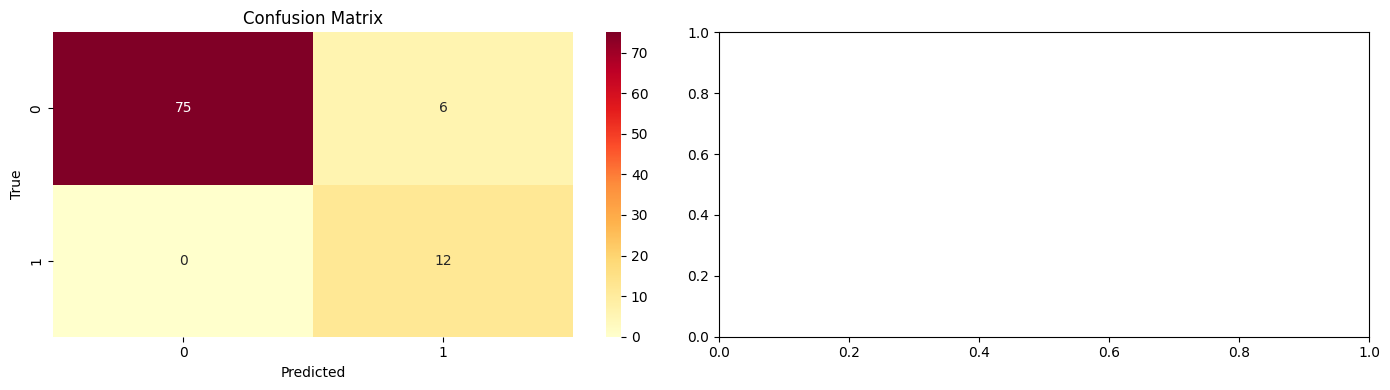

In [ ]:
# Confusion Matrix for the last fold
model = Ensemble_model.stacked_model
cm    = confusion_matrix(model.predict(x_test), y_test)

# Feature Importance for the last model
# feature_imp = pd.DataFrame({'Value':xgb_model.feature_importances_, 'Feature':x_train.columns})
# feature_imp = feature_imp.sort_values(by="Value", ascending=False)
# feature_imp_top20 = feature_imp.iloc[:20]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Subplot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Subplot 2: Feature Importance
# sns.barplot(x="Value", y="Feature", data=feature_imp_top20, ax=ax[1], palette='YlOrRd_r')
# ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

In [ ]:
submission                           = sample_submission.copy()
submission[['class_0', 'class_1']]   = Ensemble_model.stacked_model.predict_proba(test_r)
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.918026,0.081974
1,010ebe33f668,0.918026,0.081974
2,02fa521e1838,0.918026,0.081974
3,040e15f562a2,0.918026,0.081974
4,046e85c7cc7f,0.918026,0.081974
